<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; margin: 10px">

# Collaborative Filtering Recommendations with Spark Lab
Week 9 | Lesson 4.1



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pyspark 
from IPython.display import Image
from __future__ import division
from sklearn.utils import shuffle
from collections import defaultdict, Counter
from time import time
import pickle

from pyspark import SparkContext, SparkConf
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel
import math

%matplotlib inline

## Introduction

In this lab you will be going on a tour de force through the collaborative filtering recommendation system building pipeline using Spark's implementation of Collaborative Filtering. This is a project that took more than three months of research, experimentaion, and implementation to complete. Most of this project has been has been summerized and most code has been provided. The goal of this lab is to leave you with an understanding of the thought process of this pipeline and to gain some experience writing python functions using Spark RDDs. 

#### Outline

1. Assess the sparsity of the ratings and purchase matricies
2. Collaborative Filtering with Spark
2. Cold Start Problem
3. Market Segmentation
4. Convert Implict data into Explict data
5. Cross Validatation
6. Build a Collaborative Filtering Recommendation System
7. Curate Recommendations into Varietal "Sub-Genres"

### 1. Assess the sparsity of the ratings and purchase matricies



In [81]:
# load ratings data
ratings_path = "./datasets/Ratings.txt"
df_ratings = pd.read_csv(ratings_path, sep='\t')

In [82]:
# purchase data
purchase_path = "./datasets/Purchases.txt"
df_purchases = pd.read_csv(purchase_path, sep='\t')

In [7]:
# calculate number of ratings from unique users

# calculate total number of ratings


In [8]:
# calculate number of purchases from unique users

# calculate number total number of purchases 


In [9]:
# calculate the ratio between ratings from unique users and from the total 


In [10]:
# calculate the ratio between purchase from unique users and from the total


In [11]:
# calcualte the ratio between ratings from unique users and purchases from unqiue users 


In [12]:
# calculate the ratio between total ratings and total purchases 


The aggragations show us that less than 2 percent of users rate their purchase, and less than 1 percent of items have a rating. This tells us that any user-item rating matrix we construct will be extremely sparse. This will not be enough data to build a collaborative filtering model that can learn the latent features of user's purchases. 

Look at the percent of purchases that occured from unique users. This score is larger than the percent of unique users that have made a purchase and have rated a wine. However, the total_user_ratings is far smaller than unique_user_purchases. There are 100 times more users making purchases than there are rating items. This implies that we have more purchase data than we do rating data. 

This insight suggest that, if can can transform purchase data into something that resembles ratings data, then we'd have much more information about user item preferences and we'd be able to build a collaborative filltering recommendation system. This means that **we'll have to feature engineer Implicit purchase data into Explicit ratings data. **

### 2. Collaborative Filtering with Spark


### 2.1 Intuit with an Example 
Let's say that April and August have both watched *The Matrix*, *Rouge One*, *Intersteller*, and *Ex Machina*. However Apirl has watched *The Martian* and August has not. CF will do two things to give a rating for *The Martian* that it thinks will reflect August's movie preferences. 

First CF will identify the latent feature, which is the Science Fiction genre, that is common to April and August's movie preference. Second, it will notice that both April and August have seen a lot of the same Science Fiction movies and both have rated those movies similarly in the past. Since April rated *The Martian* a 9/10, the CF model will note the similarity of both people's preference in movies and the high rating that April give to *The Martian*. Therefore, the model will recommend that August watch *The Martain* -- which will correspond to a high rating. 



![](https://image.slidesharecdn.com/analyticswithcassandrasparkfrankfurt-150618181941-lva1-app6892/95/analytics-with-cassandra-spark-mllib-cassandra-essentials-day-38-638.jpg?cb=1434651656)


The above image shows how CF uses the preferences of the middle two users highlighted in green to predict a rating for the bottom users highlighted in green. 

### Qestion: Can you guess if the question mark will be replaced with a thumbs or thumbs down?

>Your answer here


### 2.2 How Collaborative Filtering works
Collaborative Filtering (CF) is a solution to the sparse matrix problem. CF implements Matrix Factoriation (MF) to decompose the rating matrix $R$ into two matrices, sometimes refered to as $U$ and $V^{T}$. These 3 matricies are used in an optimization process called Alternativing Least Squares (ALS) in order to approximate $R$ as $\hat{R}$. Unlike $R$, $\hat{R}$  has its zero values imputed with non-zero values. These non-zero values have been filled in by discovering the latent features of $R$. These latent features tell us about hidden relationships between users and items in order to fill in those missing values. 


**CHECK OUT post to get a deeper understanding of how Matrix Factorization works** [Matrix Factorization](http://recommender.no/algorithms/matrix-factorization-algorithm-works/)




![](http://ampcamp.berkeley.edu/big-data-mini-course/img/matrix_factorization.png)




Spark's implementaion of CF differs from other implementaion in where it stores and minipulates the $U$ and $V^{T}$ matricies. Spark stores $U$ and $V^{T}$ as column and row vectors 



![](https://databricks.com/wp-content/uploads/2014/07/als-illustration.png)

In [ ]:
# delete the dataframes in order to free up memory space 
del df_ratings
del df_purchases

### 2. Cold Start Problem

Collaborative filters are essentially matrix factorization models plus a similarity equation between users and items. Users who have not made a purchase introduce a row of zeros into the matrix and does not contribute any information to the factorization process. 

In the context of recommendations, users with no previous purchases can not be compared with other users who have made purchases in order to asses the similarity in their item preferences. Without any purchases, the CF model cannot uncover the latent features that drive user's purchases behavior. Thus users with zero purchases must be excluded from collaborative filters. 

Take a look at the Customers vs. Total Purchases graph. It shows that the vast, vast majority of users have made one or two purchases. The first bin (the tallest one) shows that over 200,000 users made only a single purchase in the 10 history that this data represents. 

User's with one, two, or even three purchases still might not contribute enough information to the CF in order to do a decent job at modeling their purchasing behavior, thereby leading to poor model performance. So we might consider increasing the minimum number of purchases that a user must have in order to be included in the CF model. But increasing that minimum number comes at a cost. 

If that minimum number is set too high, we'll be excluding too many people from the recommendation process. **We'll need to optimize the minimum number of purchases with respect to something that makes sense -- but what?** Keep reading. 



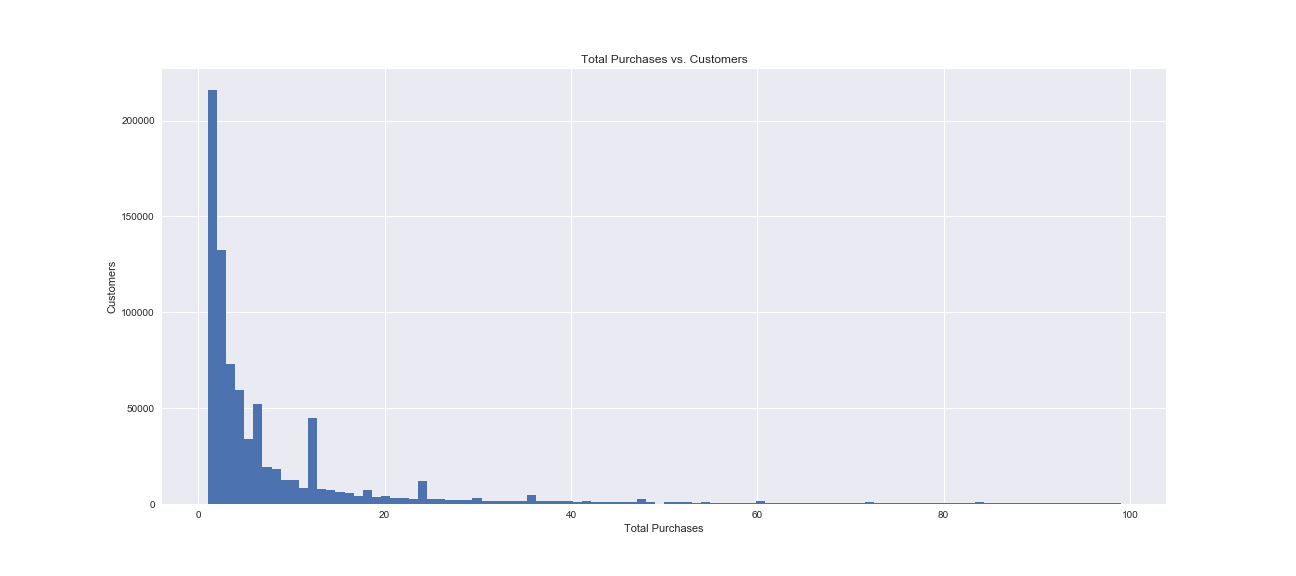

In [2]:
Image("./images/purchase_dist.png")

**NOTE ON PLOT: ** The horizontal axis has been truncated to only show the first 100 total purchases. 

### 3. Market Segmentation 

In the business world it is wise, usefull, and analytically preduent to segment users into meaningful categories. For our purposes, we're only interested in a single category. We are interested in category of users that responsible for the majority of purchases and therefore revenue. It is these users that we want our recommendation system to keep happy, engaged, purchasing, and prevent from churning. 

Countless hours of Exploratory Data Analysis lead to the following approach. 

### 3.1 Remove non red or white wine product keys from the product data
This data set contains purchases for not just wines but also various spirits and champaigns. The motivations for purchasing wines are presumably different from the motivations for purchasing 
whisky or champaign, so we need to filter those purchases out of our data set. Also, our job is to build a wine recommender so clearly we want to filter out any non-wine products.

### 3.2 Filter out customers who purchases less than 5 bottles of wines

In order to detect latent features (wine preferences of users) there needs to be enough 
purchase data present in order for patterns to emerge for each user. For this reason, we must include a minimum number of wine purchases that lead to optimium model performance. That number was shown to be 5 through cross validation. 
    
    

**Pre-filter: ** 

    Total users 719800

**Post-filter: **

    Total users 225056

By excluding users with less than 5 purchases, we have managed to retained 31.3 percent of original users. In other words, **we have droped 69 percent of users!** 


### 3.3. Filter out Customers with no subsequent transactions
The goal of the recommender is to model the purchasing behavior of recurring users. 
Users who visit the site once and never return provide detract from our goal. 

**Pre-filter: **

    Number of purchases 6628100
    Unique user 719800

**Post-filter: **

    Number of purchases 4561063
    Unique user 166563

By excluding users only made a single transaction, we managed to retained 23 percent of unique users 
and 69 percent of total purchases. 

Take a look at the number of unique users and total purchases retained. Notice that about 20 percent of users are resonsible for 70 percent of purchases. [**This follows the Pereto Principle very closely!**](https://en.wikipedia.org/wiki/Pareto_principle)


### 3.4 Remove transactions with more than K purchases

We want to remove the bulk purchases made by wedding and party planers. 
These bulk purchases, usually of a single type of wine,  don't reflect any deep wine preferences made by the typical user. 

K can be adjusted, say, bewteen 10 and 20. 
We will use a upper bound of 10 purchases for a single transaction.  

### 3.5 Market Segmentation Overview

We have segmented users in the following way:

    -Purchased wine
        - Purchased at least 5 bottles
            - At least subsequent 2 transactions
                - No more than 10 bottles in a single transaction
                
It is this subset of users that the will be used to train the recommendation model. 

### 4. Convert Implict data into Explict data
Now that we have segmented the users into a meaningful category, we want to project their purchases into a ratings space. This means that we'll need to **transform implict data into explict data**, which can be tricky. Recall purchases don't necessary reflect a perference (i.e. I can purchase a particular bottle of wine several times and rate it a 5 out of 10 -- think "two buck chuck"). 

In order to detect and extract user preferences from  purchases, we are going to give each of the wines that they purchase a relative rating based on the majority wine type that they purchased. 
    
For each user's purchased bottle of wine, 

$$ Rating_{u,w} = \frac{ N_{bottles,~ w , u} - \text{Freq}_{(bottle~|~type)~w, u} } {\sum{_{(bottles~|~type)~w, u}}}  $$

$N_{bottles}$ total number of wine purchases made by user, u 

$\text{Freq}_{(bottle~|~type)~w, u}$ frequency of purchases for type of wine (either red or white)

$\sum{_{(bottles~|~type))~w, u}}$ total number of purchase for type of wine (either red or white)

$Rating_{u,w} $ rating of wine $w$ by user $u$

#### Intuition behind this approach 

We want to capture and quantify a preference for either red or white wine for each user, then normalize that number. Although we can't say for sure that a user prefers one vinyard's Cabernet over another based on purchases (and to what extent), we can be reasonably sure that they prefer red over white if 4 out of 5 purchases are for red wines. In affect, we are giving all of user_i's red wine purchases the same rating and their white wine purchases the same rating. 


### 4.1 Distributions: Purchase space to Ratings space

The first distribution is the Total Purchases vs. Customers graph that we saw earlier. Here each bins represents how many customers made X number of purchases. 

The second distribution is the Users Ratings vs. Number of Wines. Here we have ratings as floating point values, normalized from 0 to 1. The transformation also smooth the long tail distribtuion. 

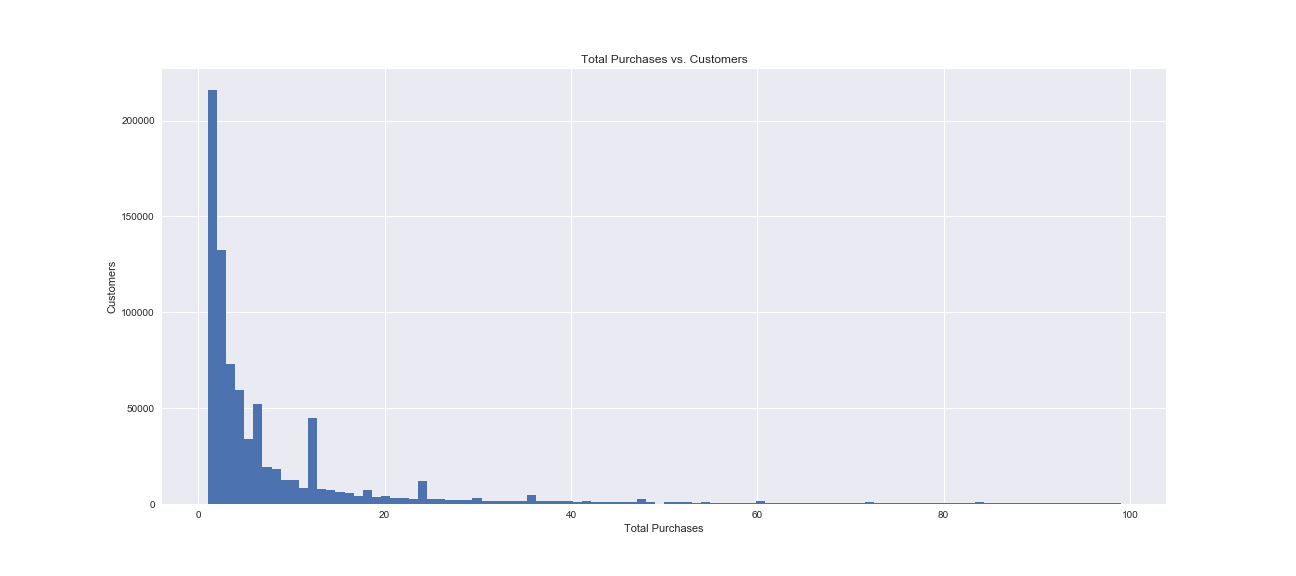

In [3]:
Image("./images/purchase_dist.png")

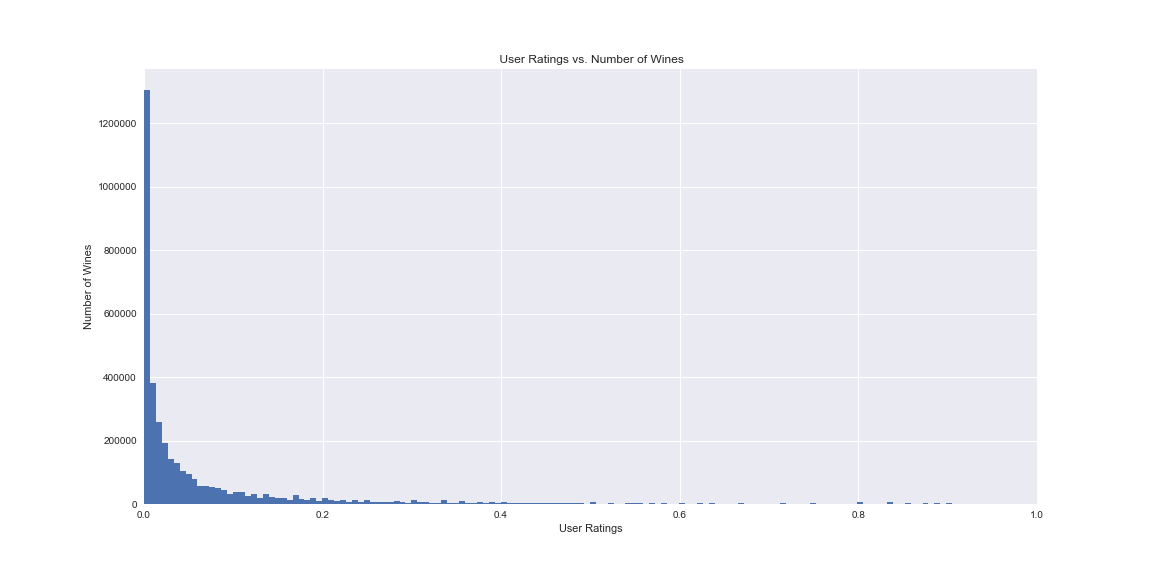

In [4]:
Image("./images/continuous_ratings_dist.png")

### 4.2 Transform floating point ratings into categorical ratings

Now that we have transformed purchase data into ratings data, we need to transform floating point values into discret values. 

This is done by partitioning the User Ratings vs. Number of Wines distribution into 10 equal sized bins. Why 10 bins? This is essentially an arbitrary number. 10 was choosen because rating a wine on a scale from 1 to 10 is readily understood by most people. 


Each bin will have an approximately equal number of values -- about 373760 floating values in each bin. Take the total number of purchased wines and divide it by 10 and you'll get approximately 373760. 

Then scan through the sorted distribution (as it appears above) and assign each value to the present bin. When that bin has reached it's capacity of about 373760, then move on from that bin and start assinging values to the next bin. Repeat this iterative process until all points have been assigned to a bin. 

Once this process is complete, we arrive at a near uniform distribution of 10 categorical values for ratings. 

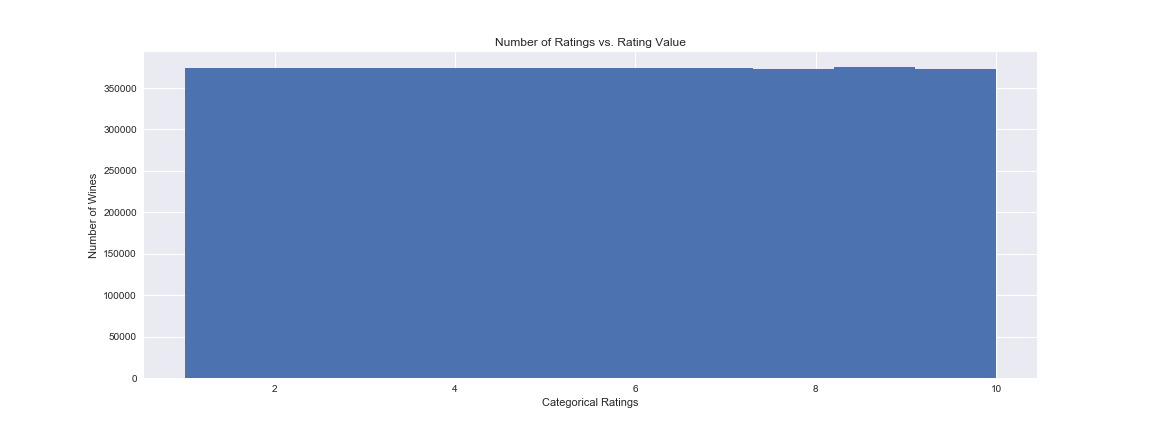

In [5]:
Image("./images/categorical_ratings.png")

### 5. Cross Validatation 

Now that we have featured engineered a Ratings matrix where rows are users and columns are wines, can finally start building the model and optimizing it's performance.

The collaborative filter will be validate in two ways. 

First we will perform a train and holdout split and record the Room Mean Squre Error as the size of the training set increases. Scoring a recommender's performance based on the RMSE is very common. In fact this is the same metric that Netflix used in their 1 million dollar Kaggle competition. 

Second, a special versional of ROC curve analysis is implemented.


### 5.1 Leave One out Cross Validation (LOOCV)


The data spans across 10 years: from 2005 to 2014. Taking advantage of this fact LOOCV is implemented by iteratively adding one year's worth of data into the training set. Each training set undergoes Stratifed KFold CV with 10 splits.  The "Stratifed" in Stratifed KFold means that equal proportions of each class (ratings from 1 through 10) will be sample for each training set; this helps avoid unbalanced classes which bias models. 

The diagram below shows how each year is iteratively moved from the test set to the training set. Intuitaively, we'd expect the model's predictive performance to increases as the size of the training set increases. 

    [TRAIN SET][       TEST SET        ]   
    ------------------------------------
    [5] [6, 7, 8, 9, 10, 11, 12, 13, 14]
    [5, 6] [7, 8, 9, 10, 11, 12, 13, 14]
    [5, 6, 7] [8, 9, 10, 11, 12, 13, 14]
    [5, 6, 7, 8] [9, 10, 11, 12, 13, 14]
    [5, 6, 7, 8, 9] [10, 11, 12, 13, 14]
    [5, 6, 7, 8, 9, 10] [11, 12, 13, 14]
    [5, 6, 7, 8, 9, 10, 11] [12, 13, 14]
    [5, 6, 7, 8, 9, 10, 11, 12] [13, 14]
    [5, 6, 7, 8, 9, 10, 11, 12, 13] [14]

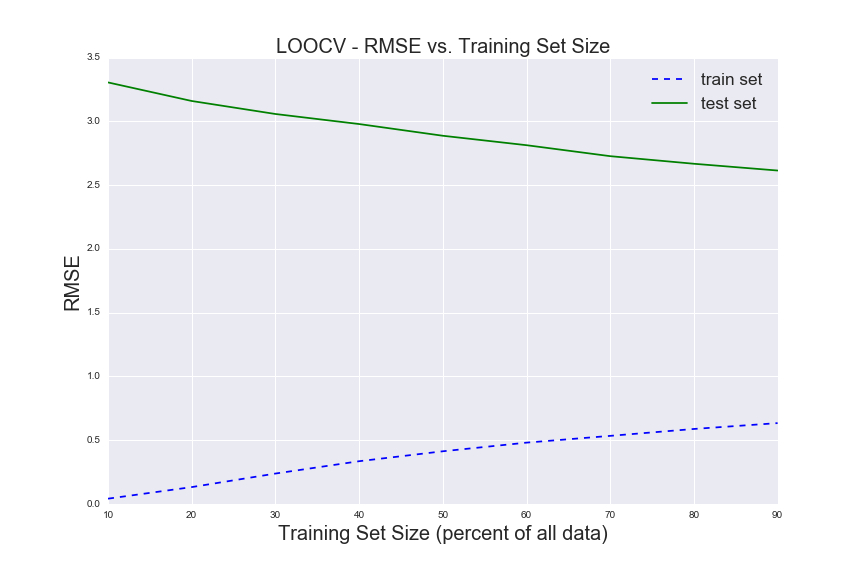

In [6]:
Image("./images/RMSE_vs_Training_Set_Size.png")

The RMSE vs. Training Set Size Learning Curve shows a few things. 

First it shows that the model's error drops from about 3.4 to 2.5 as the training set size increases from 10 percent to 90 percent of the data. We can also see that the model is overfitting, this is evident by the large gap between the train and test error curves. 

It shows that the model will be able to continue reducing its error if it were trained on more data. However we can see that the test curve's rate of change is nearly flat, so training on additonal data would bring us into the realm of diminishing returns. 

#### Compare to Navie Base Line

Whenever we assess the performance of a model, we always want to have a baseline model for comparison. A common navie base line for recommendation systems is to simply predict the the average rating every time. Doing this arrives at a RMSE of about 2.9. This means that our collaborative filter was able to improve on the navie baseline model. Though we'd like to see higher improvement. 

### Question: Can you think (research) of a way to improve the performance of a recommendation system?

Sometimes people will combime approachs, such as combining content based and collaborative filtering methods. 

>Your answer here

### 5.2 ROC Analysis for Recommendation Systems


Further model validation is performed by plotting a ROC Curve. ROC curves show the relationship between the True Positive Rate (TPR) and the False Positive Rate (FPR) as a hyper-parameter, or some other threshold value, is varied. In order to plot roc curves, the non-binary predicted ratings of the model must be transformed into a binary classification. This is achieved in the following way.




1. Ratings vary from 1 to 10. 
2. Create a threshold value, t, and vary it from 2 to 10. 
3. Ratings below the threshold, t, are given the label 0, meaning don’t recommend. 
4. Ratings above the threshold, t, are given the label 1, meaning do recommend. 
5. Test set ratings and predicted ratings are both compared to the threshold value as we iterate through threshold values (i.e. for t = i and rating = r, if r $\ge$ t then 1 else if r $\lt$ t then 0 ). 

Those 0 and 1 binary classifications enable us to build a confusion matrix that can be used to obtain true positive and false positive rates. A more detailed explanation of this procedure can be found in [An Evaluation Methodology for
Collaborative Recommender Systems](http://www.contentwise.tv/files/An-evaluation-Methodology-for-Collaborative-Recommender-Systems.pdf). 

#### The Take Away

The ROC tells us that to maximize the TPR and minimize the FPR, we need to pick a certain threshold value (a rating from the 1 to 10 scale). We will use this value in the following way. Every user in the data set will be given rating for wines that they have and have not rated before (remember that since we mapped purchases into a ratings space we can know talk about user ratings). If the rating for a particular bottle of wine is below that threshold value, we do not recommend that wine. We only recommend wines with a rating that is above the threshold value. 

Although you can't conclude this from looking at the ROC curve, the optimum threshold value is a rating of 7. 

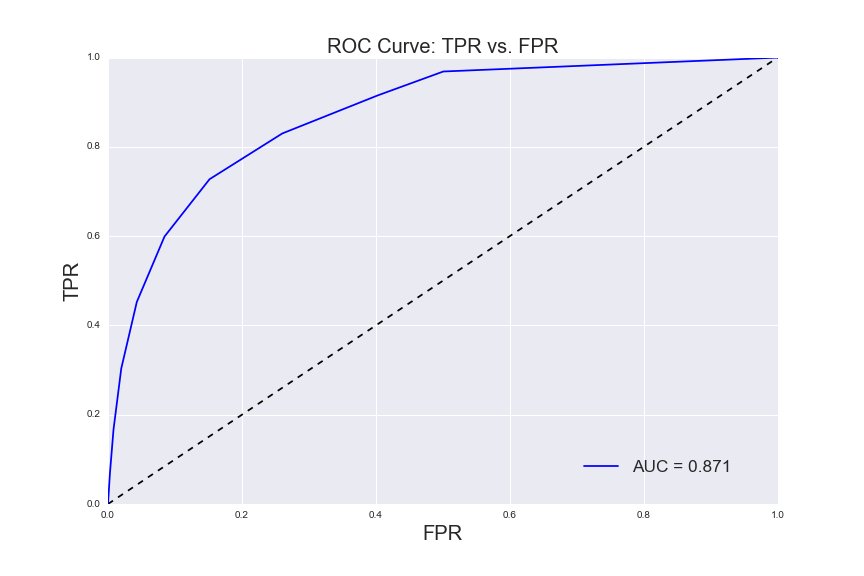

In [40]:
Image("./images/ROC_Curve.png")

## 6. Build a Recommendation System


In [11]:
home = "/Users/Alexander/Wine_Recommender/data/"
ratings_path = home + "spark_ready_data.pkl"
products_path = home + "wine_products.pkl"

In [50]:
df_products = pd.read_pickle(products_path)

#### Spark cluster

We need to initiate the spark contenxt by specifying how many cpus we want to dedicate to our spark cluster. Because we are working a large data set, I suggest that you use as many cpus as your compute has available. I also suggest that you shut down any non-essential applications that may be running. 

In [2]:
# number of nodes in local spark cluster
n_worker_cups = 
conf = SparkConf().setMaster("local[{}]".format(n_worker_cups))
sc = SparkContext(conf=conf)

#### Format Data for Spark Recommender
Data needs to be in this form --> (user_id, item_id, n_purchases)

#### Create user tags/user ids bride rdd

In [3]:
def create_cust_tag_bridge_rdd(data, sc):
    # create int:cust_tag key value pairs
    # spark can't read string user ids
    
    unique_user_tags = np.unique([row[0] for row in data])
    
    index_to_int = np.arange(0, len(unique_user_tags) * 100, 100)
    cust_tag_bridge = [ (tag_hash, tag_int) for tag_hash, tag_int in zip(unique_user_tags, index_to_int)]
    
    return sc.parallelize(cust_tag_bridge)

#### Wine Products RDD

In [4]:
def create_products_rdd(products_df):
    # create products_rdd
    products_rdd = sc.parallelize(products_df.values.tolist())
    
    # format --> (productKey, (productID, Appellation, Varietal, Vinyard) )
    products_rdd = products_rdd.map(lambda row: (row[0], (row[1], row[2], row[3], row[4], row[5]) )   )
    
    return products_rdd

#### Ratings RDD

In [5]:
def create_clean_data_rdd(data, cust_tag_bridge_rdd):
    # create bride rdd for customer tags and customer ids
    data_rdd = sc.parallelize(data)
    
    tag_data_bridge_rdd = data_rdd.map(lambda row: (row[0], (row[1], row[2]) ))
    
    clean_data_rdd = \
    tag_data_bridge_rdd.sortByKey()\
                   .join( cust_tag_bridge_rdd.sortByKey())\
                   .map(lambda row: ( row[1][1], row[1][0][0], row[1][0][1]))
            
    return clean_data_rdd

### Create get clean data rdd

In [6]:
def get_ratings_data(ratings_path):
    start = time()
    data = pickle.load(open(ratings_path, 'rb'))
    end = time()
    print ("Load Data Time Elapsed = {:.3} seconds".format(end - start))
    return data

In [7]:
def get_clean_data_rdd(sc, return_cust_brige_rdd = False):
    '''Loads ratings from master file and formats data into model readable form.
       data --> (user_id, productKey, rating)'''
    # load data
    data = get_ratings_data(ratings_path)
    # assigne each user hash tag a user_id
    cust_tag_bridge_rdd = create_cust_tag_bridge_rdd(data, sc)
    # model readable format
    clean_data_rdd = create_clean_data_rdd(data, cust_tag_bridge_rdd) 
    
    if return_cust_brige_rdd == False:
        cust_tag_bridge_rdd.unpersist()
        return clean_data_rdd
    else:
        return clean_data_rdd, cust_tag_bridge_rdd

### Create Train model 
    Here we will train the model on the entire data set. The hyper-parameters has been validate during cros

In [8]:
def train_model(training_RDD):
    seed = 5
    iterations = 20
    regularization_parameter = 0.1
    rank = 16

    model = ALS.train(training_RDD, 
                      rank=rank, 
                      seed=seed, 
                      iterations=iterations,
                      lambda_=regularization_parameter,
                      nonnegative=True)
    return model

### Create get_fitted Model 

In [9]:
def get_fitted_model(sc, ratings_path):
    '''Loads rating data from file, trains model, and returns a fitted model'''
    
    print ("load data and build RDDs...")
    clean_data_rdd = get_clean_data_rdd(sc)
    
    print ("Training Model...")
    start = time()
    fitted_model = train_model(clean_data_rdd )
    end = time()
    print ("Training Model: Time Elapsed = {:.3} \n".format(end - start))
    
    # restore memory resources
    clean_data_rdd.unpersist()
    
    return fitted_model

In [13]:
# run get_fitted_model in order to fit the model
# save output as fitted_model


### Get K Recommendations for a User

1. For some ith user, remove their purchased wines from the total data.
2. Get predicted rating on all previously unpurchased wines. 
3. Filter recomendations based on the rating threshold value that was validated during cross validation (i.e. 7) 
4. Curate recommendations for presentation 

In [13]:
# will get K predictions for user with this id
user_id = 0

In [14]:
# run get_clean_data_rdd save the out as clean_data_rdd and cust_tag_bridge_rdd 
# set return_cust_brige_rdd to True


Let's now get some recommendations! For that we will get an RDD with all the movies the new user hasn't rated yet. We will input them into the model in order to predict ratings


In [16]:
# ( user_id, movie_id, rating  )
# get user_id 0's movie ids in a list
movie_ids = clean_data_rdd.filter(lambda row: row[0] == user_id )\
                           .map(lambda row: row[1]).collect()

In [16]:
# use the .take method to print out the first 5 values of movie_ids


In [18]:
# get wine_ids that user_id has not purchased 
unpurchased_wines = \
clean_data_rdd.filter(lambda row: row[0] != user_id )\
    .filter(lambda row: row[2] not in  movie_ids)\
    .map(lambda row: (user_id, row[1] ) ).distinct()

In [17]:
# rdd contains (user_id, movie_id) pairs 
# use the .count and .take .methods on unpurchased_wines to get a print out 


In [22]:
def get_userID_moiveID_pairs(user_id, clean_data_rdd):
    '''In order to get recommendations for a user, we need to build an RDD with (user_id, wine_id)
       pairs for wines that the user has not previously purchased.'''
    # ( user_id, movie_id, rating  )
    # get user_id 0's movie ids in a list
    movie_ids = clean_data_rdd.filter(lambda row: row[0] == user_id )\
                              .map(lambda row: row[1]).collect()
        
    # get wine_ids that user_id has not purchased 
    unpurchased_wines = clean_data_rdd.filter(lambda row: row[0] != user_id )\
                                      .filter(lambda row: row[2] not in  movie_ids)\
                                      .map(lambda row: (user_id, row[1] ) ).distinct()
    return unpurchased_wines

In [23]:
# run get_userID_moiveID_pairs 
# save output to variable unpurchased_wines


In [18]:
# use the .take method on unpurchased_wines
# explain what the output is


#### Get Recommendations for Single User

In [19]:
# Use the .predictAll on fitted_model to get recommendations for user
# save the result to variable user_recs


In [27]:
# your user recommendation should look something like this 
user_recs.take(5)

[Rating(user=0, product=185012, rating=4.508028184183978),
 Rating(user=0, product=354796, rating=3.740411353249598),
 Rating(user=0, product=364608, rating=6.7881637763544855),
 Rating(user=0, product=143464, rating=4.422797417105195),
 Rating(user=0, product=155312, rating=6.168732817161046)]

### Distribution of Predicted Ratings for User

In [20]:
# user the .collect method to pull all the ratings from user_recs into memory and save it to a local variable
# save the output to variable local_ratings


In [ ]:
# plot the distribution of the ratings from local_ratings


### Apply Threshold

In [41]:
# value validated during cross validation 
threshold = 7

In [42]:
# filter recommendations from user_recs that are less than the threshold  
# save the results to variable validated_user_recs


### Make Recommendations Human Readable
Retreive the users' customerhash and the wine's features

In [53]:
def format_user_recs(user_recs, products_rdd, cust_tag_bridge_rdd, thresh = 9):
    '''Reformat user recommendations so it's human readable and in preperation for curation.
       This function swaps the user_id back to the original user hash tag, and attachs the wine
       features (i.e. productID, appellation, varieatl, ...) '''
    
    # value validated in Spark_Recommendation_Model_Validation notebook
    threshold = thresh
    validated_user_recs = user_recs.filter(lambda row: row[2] >= threshold )
    
    # format --> (product key, predicted rating, user hash tag)
    wineID_rating_userHash = \
    validated_user_recs.map(lambda row:  (row[0], (row[1], row[2]) )  )\
                       .join(cust_tag_bridge_rdd\
                       .map(lambda row: (row[1], row[0])))\
                       .map(lambda row: (row[1][0][0],
                                        (row[1][0][1],
                                         row[1][1] ) ))  
            
            
         
            
            
    # Key:Value pair RDD
    # format --> (custumer tag, (productKey , productID, Appellation, Varietal, Vineyard, wine type, Rating  ) )  
    clean_user_recs = \
    wineID_rating_userHash.join(products_rdd)\
                          .map(lambda row: ( row[1][0][1], 
                                             (row[0], 
                                              row[1][1][0], 
                                              row[1][1][1], 
                                              row[1][1][2], 
                                              row[1][1][3],
                                              row[1][1][4],
                                              row[1][0][0])))
    return clean_user_recs

In [54]:
# run create_products_rdd
# save output to variable products_rdd



In [21]:
# (custumer tag,  (productKey , productID, Appellation, Varietal, Vineyard, wine type, Rating  ) )

# run format_user_recs
# save output to clean_user_recs_rdd


The output of the clean_user_recs_rdd function are our semi-final recommendations for the user. Each recommended wine appears in a tuple with several other feautres as key-value pairs 

**(custumer tag,   (productKey , productID, Appellation, Varietal, Vineyard, wine type, Rating  ) )**



In [71]:
# your output should look something like this 
clean_user_recs_rdd.take(2)

[('00000F7264C27BA6FEA0C837ED6AA0AA',
  (12,
   118342,
   'Other Spain',
   'Grenache',
   'Evodia',
   'Red Wines',
   8.024590131168189)),
 ('00000F7264C27BA6FEA0C837ED6AA0AA',
  (262164,
   85231,
   'Other California',
   'Pinot Noir',
   'Camelot',
   'Red Wines',
   8.190527720509952))]

### 7. Curate Recommendations into Varietal "Sub-Genres"

Now that we have our recommendations, we need to think about how we are going to select from among them and how we going to present the recommendations to the user. 

We are going to select the top 3 rated wines from the top 3 most recommended varietals. 

In [75]:
def curate_top_wines(top_varietal_recs, top_varietals):
    final_recs = defaultdict(list)
    for var in top_varietals:
        var_cnt = 1
        for row in top_varietal_recs:
            if row[1][3] == var:
                # number of varietals is hard coded -- modify this if you desire 
                if var_cnt <= 3:
                    var_cnt += 1
                    final_recs[row[0]].append(row[1][:-1])
    return final_recs

In [76]:
def get_top_rec_varietals(clean_user_recs):
    '''Returns the top 3 wines from the top 3 varietals for user'''
    
    # { custumer tag : (productKey , productID, Appellation, Varietal, Vineyard, wine type, Rating  ) }
    user_recs_key_value_tuple = clean_user_recs.collect()
    
    # varietal name of wine  
    varietals = [row[1][3] for row in user_recs_key_value_tuple]
    
    var_count = Counter(varietals)
    
    # get top 3 most recommender varietals for this user
    # number of wines to return is hard coded -- modify this if you desire 
    top_varietals =  [row[0] for row in var_count.most_common()[0:3]] 
    
    top_varietal_recs = clean_user_recs.filter(lambda row: row[1][3] in  top_varietals ).collect()
    
    return curate_top_wines(top_varietal_recs, top_varietals)

In [77]:
# run get_top_rec_varietals
# save output to final_recs


In [80]:
# your output should looks similar 
# {custumer tag : (productKey , productID, Appellation, Varietal, Vineyard, wine type ) )
print final_recs.keys()
final_recs.values()[0]

['00000F7264C27BA6FEA0C837ED6AA0AA']


[(262188,
  84808,
  'Sonoma County',
  'Chardonnay',
  'Kendall-Jackson',
  'White Wines'),
 (262260, 78140, 'Santa Maria Valley', 'Chardonnay', 'Cambria', 'White Wines'),
 (393468, 79324, 'Willamette Valley', 'Chardonnay', 'Argyle', 'White Wines'),
 (262596,
  75352,
  'Other California',
  'Sauvignon Blanc',
  'Dancing Bull',
  'White Wines'),
 (900, 129813, 'Other California', 'Sauvignon Blanc', 'Rusack', 'White Wines'),
 (415212,
  84980,
  'Columbia Valley',
  'Sauvignon Blanc',
  'Barnard Griffin',
  'White Wines'),
 (131928, 92229, 'Napa Valley', 'Cabernet Sauvignon', 'Duckhorn', 'Red Wines'),
 (394824,
  73461,
  'South Africa',
  'Cabernet Sauvignon',
  'Graham Beck',
  'Red Wines'),
 (263988, 113108, 'Sonoma County', 'Cabernet Sauvignon', 'Simi', 'Red Wines')]